# Bit set counts

* https://adventofcode.com/2021/day/3

We are tasked with counting bits in each column of input, to produce two binary numbers. While there are [some great algorithms for bit counting](https://graphics.stanford.edu/~seander/bithacks.html#CountBitsSetNaive), the fact that we are counting bits across columns means we need to use a slightly different approach.

The input, can be 'processed' by indexing into the column and testing if that column is equal to `'1'`, and summing these booleans (which in Python have integer values `0` and `1`) gives us the number of rows with the bit set. You can then compare that value with the number of lines and set the corresponding bit in gamma and epsilon (with epsilon being the inverse of gamma). By starting at the left-most column, and left-shifting the accumulated gamma and epsilon values, we naturally build up the bits in the correct order.

In [7]:
def power_consumption(report: list[str]) -> int:
    width = len(report[0])
    threshold = (len(report) + 1) // 2  # handles odd and even line lengths
    gamma = epsilon = 0
    for k in range(width):
        # The puzzle description just talks about 'most common'; it doesn't
        # matter to _my_ puzzle input if we break ties in favour of 1s or 0s.
        one_most_common = sum(line[k] == "1" for line in report) >= threshold
        gamma = gamma << 1 | one_most_common
        epsilon = epsilon << 1 | (not one_most_common)
    return gamma * epsilon


test_report = """\
00100
11110
10110
10111
10101
01111
00111
11100
10000
11001
00010
01010
""".splitlines()

assert power_consumption(test_report) == 198


In [8]:
import aocd
diagnostic_report = aocd.get_data(day=3, year=2021).splitlines(False)
print("Part 1:", power_consumption(diagnostic_report))

Part 1: 845186


# Part 2: Reducing the input numbers based on bit counts

Instead of accumulating a bit for each column in two numbers, we need to reduce the input lines based on the outcome. We'll have to assume that the puzzle inputs will always lead to a a single line out output for this process.

For each column index, calculate the threshold, determine if the `'1'` count is high enough, filter the lines based on the column value and and repeat until there is a single line left. Only then do we need to convert from string of binary digits to a number.

This approach takes $O(n \log_2 n)$ time as we repeatedly pass over the lines but (roughly) half the number each time.

In [9]:
def life_support_rating(report: list[str]) -> int:
    width = len(report[0])

    def reduce(lines: list[str], filter_on="01") -> int:
        for k in range(width):
            threshold = (len(lines) + 1) // 2
            one_most_common = sum(line[k] == "1" for line in lines) >= threshold
            lines = [line for line in lines if line[k] == filter_on[one_most_common]]
            if len(lines) == 1:
                return int(lines[0], 2)

    oxygen_generator_rating = reduce(report)
    co2_scrubber_rating = reduce(report, filter_on="10")
    return oxygen_generator_rating * co2_scrubber_rating


assert life_support_rating(test_report) == 230


In [10]:
print("Part 2:", life_support_rating(diagnostic_report))

Part 2: 4636702


# Optimising part 2 using a binary tree

We can also solve this challenge using a binary tree.

Instead of repeatedly looping over the lines to count and then filter, we could build a binary tree structure from the inputs. Each node has left and right subtrees for `0` and `1`, as well as a count of the number of lines that have the same prefix up to this point. Producing the two values is then just a question of following the correct branch down to the leaf, all the while shifting the collected value and including the selected direction via bitwise OR, like in part 1. Here, "following the correct branch" means comparing the two counts at that node in the tree and following the higher or lower count to the next node; and what direction you followed determines if a `0` or `1` is added to the accumulating value.

This approach is also a $O(n \log_2 n)$ solution; constructing the btree loops over all $n$ lines and then over $\log2 n$ bits on each line; reading out the numbers is a fixed cost at the end.

And while I'm fond of using OOP for many of my AoC solutions, the binary tree here can trivially be stored in a list instead; just like 
a [the most common implementation of a heap](https://en.wikipedia.org/wiki/Heap_%28data_structure%29#Implementation), a given node for binary value $v_k$ at a given depth $k$ is found at $2^{k} - 2 + v_k$. We'll need a list of length $2^{k + 1} - 2$, and because each cell represents a line count, the values all start at `0`. E.g., given the inputs `001`, `101`, `110` and `111`, you'd create a btree with the following structure:

<!-- 
digraph G {
  graph [splines=line,size=3];
  node [shape=circle,fontname="Arial,Helvetica Neue,Helvetica,sans-serif",fontsize=10.0];
  edge [fontname="Arial,Helvetica Neue,Helvetica,sans-serif",fontsize=10.0,dir=none,labeldistance=3];
  
  root -> node0 [taillabel="0"];
  root -> node1 [taillabel="1",labelangle=25];
  node0 -> node00 [taillabel="00"];
  node0 -> node01 [taillabel="01",labelangle=30,labeldistance=2];
  node1 -> node10 [taillabel="10",labeldistance=2];
  node1 -> node11 [taillabel="11",labelangle=25];
  node00 -> node000 [taillabel="000"];
  node00 -> node001 [taillabel="001",labelangle=40,labeldistance=2];
  node01 -> node010 [taillabel="010"];
  node01 -> node011 [taillabel="011",labelangle=25];
  node10 -> node100 [taillabel="100"];
  node10 -> node101 [taillabel="101",labelangle=25];
  node11 -> node110 [taillabel="110",labelangle=-40,labeldistance=2];
  node11 -> node111 [taillabel="111",labelangle=25];
  
  root[label="4",style=dashed];
  
  node0[label="1"];
  node1[label="3"];
  
  node00[label="1"];
  node01[label="0"];
  node10[label="1"];
  node11[label="2"];
  
  node000[label="0"];
  node001[label="1"];
  node010[label="0"];
  node011[label="0"];
  node100[label="0"];
  node101[label="1"];
  node110[label="1"];
  node111[label="1"];
}
-->

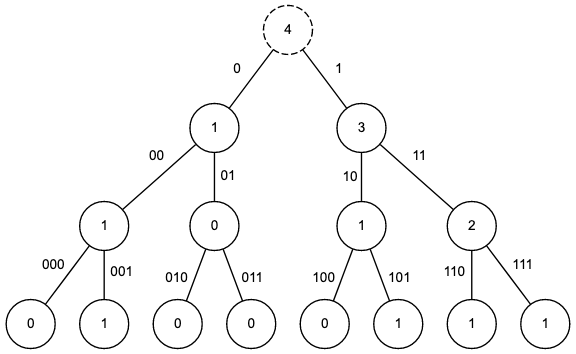

which can be stored in a list starting at the first two nodes under the root at indices 0 and 1, the 2 left hand-side nodes at the next level (representing lines that start with `0`) in indices 2 and 3, then 4 and 5 contain the counts for everything starting with `1`, and so on:

```python
btree = [1, 3, 1, 0, 1, 2, 0, 1, 0, 0, 0, 1, 1, 1]
#        0  1  0  0  1  1  0  0  0  0  1  1  1  1 
#        .  .  0  1  0  1  0  0  1  1  0  0  1  1
#        .  .  .  .  .  .  0  1  0  1  0  1  0  1
```

I've dropped the `- 2` subtractions to simplify the code, and just live with two extra unused positions in my btree list.

In [13]:
from operator import ge, lt


def life_support_rating_btree(report: list[str]) -> int:
    # build a btree in a list (first two elements are left untouched)
    # with each node representing the number of lines that have the same
    # bit prefix. e.g. `0` and `1` give the btree [0, 0, 0, 1], while
    # `01`, `10` and `11` produces `[0, 0, 1, 2, 0, 1, 1, 1]`.
    depth = len(report[0])
    btree = [0] * (2 << depth)
    for line in report:
        v, offset = 0, 1
        for c in line:
            offset <<= 1
            v = (v << 1) | (c == "1")
            btree[offset + v] += 1

    def rating(op=ge):
        # Walk the btree to reduce the line count down to 1 by choosing either
        # the left (0) or right (1) child node for the given comparison operator
        # comparing between the line counts.
        v, offset = 0, 1
        for _ in range(depth):
            offset <<= 1
            v <<= 1
            idx = offset + v
            bit = op(btree[idx + 1], btree[idx])  # #(1) >= #(0) or #(1) < #(0)
            if op is lt and btree[idx + bit] == 1:
                # We've reduced the tree to a single line, reconstruct the
                # remainder by always using >= (instead of < for the co2
                # scrubber rating)
                op = ge
            v += bit

        return v

    oxygen_generator_rating = rating()
    co2_scrubber_rating = rating(lt)
    return oxygen_generator_rating * co2_scrubber_rating


assert life_support_rating_btree(test_report) == 230


In [12]:
print("Part 2:", life_support_rating(diagnostic_report))

Part 2: 4636702
